<a href="https://colab.research.google.com/github/Sajish06/task5/blob/main/task5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq install -y graphviz
!pip install -q pydotplus

import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
from IPython.display import Image, display
import pydotplus

In [2]:
from google.colab import files
uploaded = files.upload()

import io
fname = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[fname]))
print("Loaded", fname, "shape:", df.shape)
display(df.head())

Saving heart.csv to heart.csv
Loaded heart.csv shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [3]:
print("Columns:", list(df.columns))
print("\nInfo:")
display(df.info())
print("\nBasic stats:")
display(df.describe())

print("\nMissing values per column:")
print(df.isnull().sum())

if 'target' not in df.columns:
    for alt in ['Target','diagnosis','HeartDisease','heart_disease']:
        if alt in df.columns:
            df.rename(columns={alt:'target'}, inplace=True)
            print("Renamed", alt, "-> target")

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(include=['object','category']).columns.tolist()
for c in num_cols:
    if df[c].isnull().sum() > 0:
        df[c].fillna(df[c].median(), inplace=True)
for c in cat_cols:
    if df[c].isnull().sum() > 0:
        df[c].fillna(df[c].mode()[0], inplace=True)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for c in cat_cols:
    df[c] = le.fit_transform(df[c].astype(str))

print("\nAfter preprocessing, shape:", df.shape)
display(df.head())

Columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


None


Basic stats:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000



Missing values per column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

After preprocessing, shape: (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [6]:
if 'target' not in df.columns:
    raise ValueError("No 'target' column found. Please inspect your dataset and rename the label column to 'target'.")

X = df.drop(columns=['target'])
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (820, 13) Test shape: (205, 13)


In [7]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

y_pred = dt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Decision Tree accuracy (test):", acc)
print("\nClassification report:")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

Decision Tree accuracy (test): 0.9853658536585366

Classification report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

Confusion matrix:
 [[100   0]
 [  3 102]]


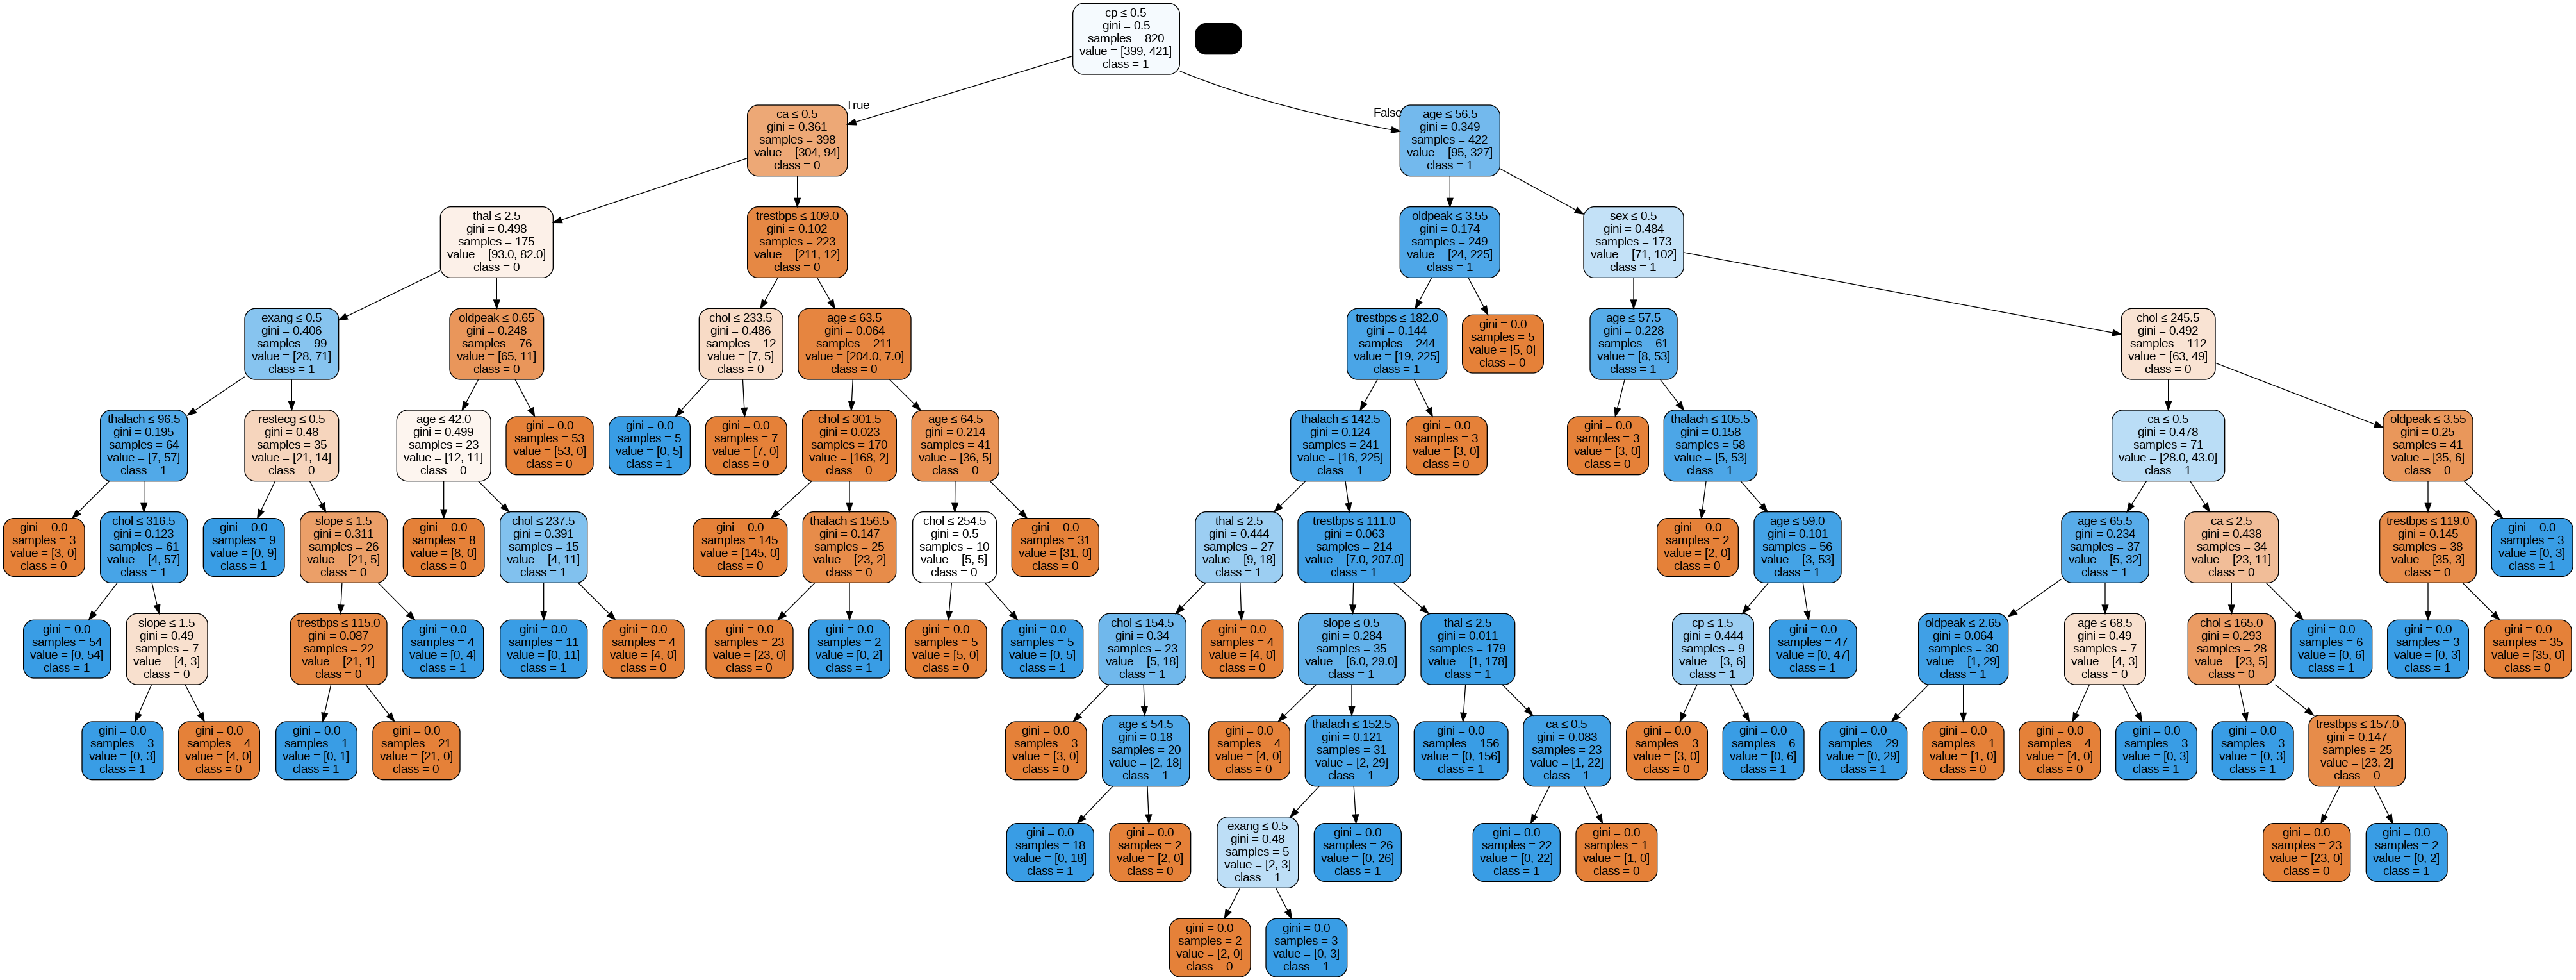

In [9]:
dot_data = export_graphviz(dt, out_file=None,
                           feature_names=X.columns,
                           class_names=['0','1'],
                           filled=True, rounded=True,
                           special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('decision_tree.png')
display(Image('decision_tree.png'))

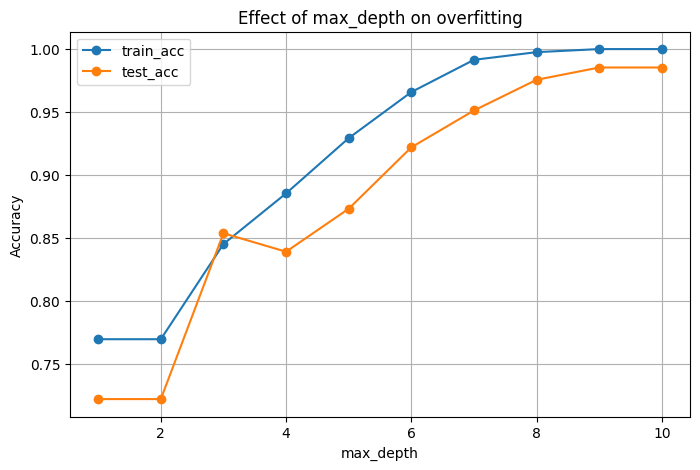

Best test acc 0.9854 at max_depth = 9


In [10]:
depths = list(range(1, 11))
train_scores = []
test_scores = []
for d in depths:
    model = DecisionTreeClassifier(max_depth=d, random_state=42)
    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    test_scores.append(model.score(X_test, y_test))

plt.figure(figsize=(8,5))
plt.plot(depths, train_scores, marker='o', label='train_acc')
plt.plot(depths, test_scores, marker='o', label='test_acc')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Effect of max_depth on overfitting')
plt.legend()
plt.grid(True)
plt.show()

best_idx = int(np.argmax(test_scores))
print("Best test acc {:.4f} at max_depth = {}".format(test_scores[best_idx], depths[best_idx]))

In [11]:
best_depth = depths[best_idx]
dt_tuned = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_tuned.fit(X_train, y_train)
print("Tuned Decision Tree test accuracy:", accuracy_score(y_test, dt_tuned.predict(X_test)))
print(classification_report(y_test, dt_tuned.predict(X_test)))

Tuned Decision Tree test accuracy: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205



In [13]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest test accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report (RF):")
print(classification_report(y_test, y_pred_rf))

Random Forest test accuracy: 1.0

Classification Report (RF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       105

    accuracy                           1.00       205
   macro avg       1.00      1.00      1.00       205
weighted avg       1.00      1.00      1.00       205



In [14]:
print("DT (tuned) test acc:", accuracy_score(y_test, dt_tuned.predict(X_test)))
print("RF test acc:", accuracy_score(y_test, y_pred_rf))

DT (tuned) test acc: 0.9853658536585366
RF test acc: 1.0


,feature,importance
2,cp,0.142094
7,thalach,0.117349
11,ca,0.114844
9,oldpeak,0.112634
12,thal,0.095930
0,age,0.091285
4,chol,0.077771
8,exang,0.073707
3,trestbps,0.067765
10,slope,0.048711


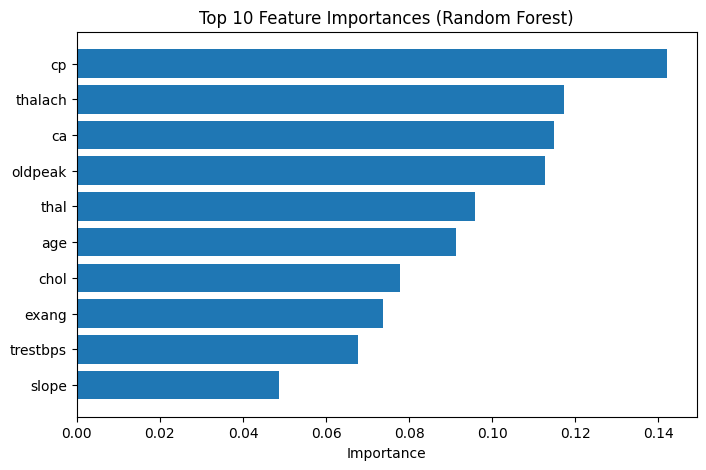

In [15]:
importances = rf.feature_importances_
feat_imp = pd.DataFrame({'feature': X.columns, 'importance': importances})
feat_imp.sort_values('importance', ascending=False, inplace=True)
display(feat_imp)

plt.figure(figsize=(8,5))
plt.barh(feat_imp['feature'].head(10)[::-1], feat_imp['importance'].head(10)[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.show()

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
dt_cv_scores = cross_val_score(DecisionTreeClassifier(max_depth=best_depth, random_state=42),
                               X, y, cv=cv, scoring='accuracy', n_jobs=-1)
rf_cv_scores = cross_val_score(RandomForestClassifier(n_estimators=100, random_state=42),
                               X, y, cv=cv, scoring='accuracy', n_jobs=-1)

print("Decision Tree CV accuracy: mean={:.4f}, std={:.4f}".format(dt_cv_scores.mean(), dt_cv_scores.std()))
print("Random Forest CV accuracy: mean={:.4f}, std={:.4f}".format(rf_cv_scores.mean(), rf_cv_scores.std()))

Decision Tree CV accuracy: mean=0.9971, std=0.0059
Random Forest CV accuracy: mean=0.9961, std=0.0078


In [17]:
from sklearn.model_selection import cross_val_predict
y_scores_rf = cross_val_predict(rf, X, y, cv=cv, method='predict_proba', n_jobs=-1)[:,1]
print("Overall RF ROC AUC (cv predictions):", roc_auc_score(y, y_scores_rf))

Overall RF ROC AUC (cv predictions): 1.0


In [18]:
params = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(RandomForestClassifier(random_state=42), params, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train, y_train)
print("Best params:", gs.best_params_)
print("Best CV score:", gs.best_score_)
best_rf = gs.best_estimator_
print("Test accuracy of best RF:", accuracy_score(y_test, best_rf.predict(X_test)))

Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best CV score: 0.9707494452019999
Test accuracy of best RF: 1.0


In [19]:
import joblib
joblib.dump(best_rf, 'best_random_forest.pkl')
print("Saved model to best_random_forest.pkl")

Saved model to best_random_forest.pkl
